# TFHub 를 이용한 Transfer Learning

* https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%202/Examples/transfer_learning.ipynb

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

## Dataset 준비

In [5]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images'.format(num_examples))

The Dataset has a total of:
• 2 classes
• 23,262 images


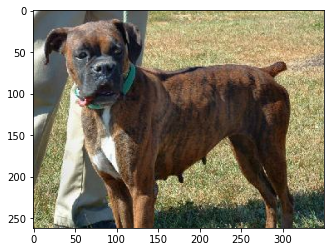

In [6]:
class_names = ['cat', 'dog']
for image, label in train_examples.take(1):
    image = image.numpy()
    label = label.numpy()
plt.imshow(image)
plt.show()

## Load tensorflow hub feature vector

In [10]:
MODULE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
IMAGE_SIZE =(224, 224)
FV_SIZE = 1280

feature_extractor = hub.KerasLayer(MODULE, input_shape=IMAGE_SIZE +(3,))


print("Using {} with input size {} and output dimension {}.".format('mobilenet_v2', IMAGE_SIZE, FV_SIZE))

Using mobilenet_v2 with input size (224, 224) and output dimension 1280.


## data pipeline

In [12]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image). \
    batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE). \
    prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE)


## build the model

In [13]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Perform Fine Tuning

In [16]:
feature_extractor.trainable = True
optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)  # slow learning

In [17]:
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
EPOCHS = 1
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

  2/582 [..............................] - ETA: 41s - loss: 0.9065 - accuracy: 0.5312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0424s vs `on_train_batch_end` time: 0.0992s). Check your callbacks.


582/582 [==============================] - 79s 136ms/step - loss: 0.1536 - accuracy: 0.9724 - val_loss: 0.1212 - val_accuracy: 0.9867


## Evaluate

In [20]:
eval_results = model.evaluate(test_batches, verbose=0)

for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.4}'.format(value))

loss: 0.1161
accuracy: 0.9884
